In [1]:
import requests
import pandas as pd
import pymongo
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Connect to MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["modified_covid"]
collection_world = db["world"]
collection_nepal = db["nepal"]

In [3]:
url = "https://covid-193.p.rapidapi.com/statistics"
url_nep = "https://covid-193.p.rapidapi.com/statistics?country=nepal"
headers = {
    "X-RapidAPI-Key": "5f22f022b4msh5c9d7483e3ec13cp138b95jsna2eb5fadd5eb",
    "X-RapidAPI-Host": "covid-193.p.rapidapi.com"
}

# Fetch data from the API
response = requests.get(url, headers=headers)
response_nep = requests.get(url_nep, headers=headers)
data = response.json()["response"]
data_nep = response_nep.json()["response"]

In [4]:
# Convert data to pandas DataFrame
df_world = pd.DataFrame(data)
print(df_world.head())
print()
# Assuming you have a DataFrame called df_world

# Create a boolean mask to filter out rows with unwanted country values
mask = ~df_world['country'].isin(['All', 'Asia', 'Africa', 'Europe', 'North-America', 'North-America', 'South-America', 'Oceania'])
df_filtered = df_world[mask]
# Apply the mask to the DataFrame to keep only the desired rows
df_filtered = df_filtered.dropna(subset=['continent'])

df_nepal = pd.DataFrame(data_nep)

# Save
collection_world.delete_many({})  # Clear existing data in collection
collection_nepal.delete_many({})  # Clear existing data in collection
collection_world.insert_many(df_filtered.to_dict("records"))
collection_nepal.insert_many(df_nepal.to_dict("records"))

       continent                country  population   
0  North-America               Anguilla     15230.0  \
1  North-America  Saint-Pierre-Miquelon      5759.0   
2        Oceania                 Tuvalu     12066.0   
3         Africa           Saint-Helena      6115.0   
4  South-America       Falkland-Islands      3539.0   

                                               cases   
0  {'new': None, 'active': 13, 'critical': 4, 're...  \
1  {'new': None, 'active': 1001, 'critical': 1, '...   
2  {'new': None, 'active': 2805, 'critical': None...   
3  {'new': None, 'active': 2164, 'critical': None...   
4  {'new': None, 'active': 0, 'critical': None, '...   

                                         deaths   
0   {'new': None, '1M_pop': '788', 'total': 12}  \
1    {'new': None, '1M_pop': '347', 'total': 2}   
2  {'new': None, '1M_pop': None, 'total': None}   
3  {'new': None, '1M_pop': None, 'total': None}   
4  {'new': None, '1M_pop': None, 'total': None}   

                         

In [5]:
data = collection_nepal.find_one()
# Extract the required values
total_cases = data['cases']['total']
recovered = data['cases']['recovered']
active_cases = data['cases']['active']
new_cases = data['cases']['new']
deaths = data['deaths']['total']
tests = data['tests']['total']

print("Total Covid Cases in Nepal :", total_cases)
print("Total Recovered Covid Cases in Nepal :", recovered)
print("Total Active Cases :", active_cases)
print("New Cases :",new_cases)
print("Total deaths on Nepal due to covid :", deaths)
print("Total test done :", tests)


Total Covid Cases in Nepal : 1003327
Total Recovered Covid Cases in Nepal : 991263
Total Active Cases : 33
New Cases : +2
Total deaths on Nepal due to covid : 12031
Total test done : 6044920


Total Covid Cases world wide : 689427630
Total Recovered Covid Cases world wide : 621189313
Total Active Cases : 6875916
Total deaths worldwide due to covid : 6883710
Total test worldwide : 6992666422


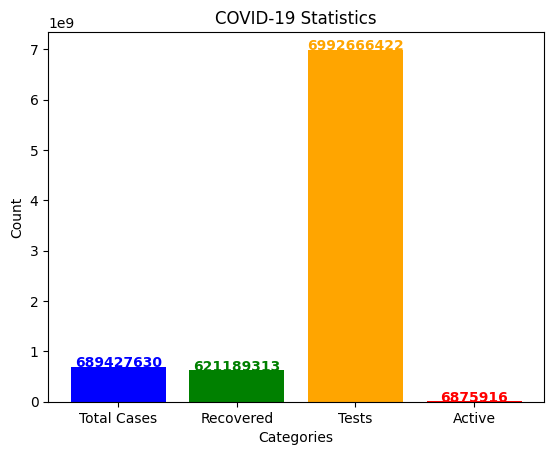

In [15]:
total_cases_data_world = collection_world.aggregate([
    {"$group": {"_id": "$continent", "total_cases": {"$sum": "$cases.total"}, 
                "total_recovered": {"$sum": "$cases.recovered"}, "total_deaths": {"$sum": "$deaths.total"}
              ,"total_test":{"$sum":"$tests.total"},
               "total_active":{"$sum":"$cases.active"}}},
    ])
# Extract the continents and total cases as separate lists
continents = []
total_cases = []
total_recovered=[]
total_active=[]
total_deaths=[]
total_test=[]

for continent in total_cases_data_world:
    continents.append(continent["_id"])
    total_cases.append(continent["total_cases"])
    total_recovered.append(continent["total_recovered"])
    total_active.append(continent["total_active"])
    total_deaths.append(continent["total_deaths"])
    total_test.append(continent["total_test"])
    
total_cases_world = sum(total_cases)
total_recovered = sum(total_recovered)
total_active = sum(total_active)
total_deaths = sum(total_deaths)
total_test = sum(total_test)

print("Total Covid Cases world wide :", total_cases_world)
print("Total Recovered Covid Cases world wide :", total_recovered)
print("Total Active Cases :", total_active)
print("Total deaths worldwide due to covid :", total_deaths)
print("Total test worldwide :", total_test)



categories = ['Total Cases', 'Recovered', 'Tests', 'Active']
values = [total_cases_world, total_recovered, total_test, total_active]

colors = ['blue', 'green', 'orange', 'Red']

plt.bar(categories, values, color=colors)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('COVID-19 Statistics')

# Add a legend with the data
for category, value, color in zip(categories, values, colors):
    plt.text(category, value + 5000, str(value), ha='center', color=color, weight='bold')

plt.show()


{'China': 503302, 'Macao': 3620, 'Tajikistan': 17786, 'Yemen': 11945, 'Bhutan': 62670, 'Timor-Leste': 23444, 'Syria': 57608, 'Palestine': 621008, 'Oman': 399449, 'Saudi-Arabia': 841469, 'Maldives': 186625, 'Cyprus': 660854, 'Mongolia': 1008655, 'Uzbekistan': 253662, 'Kyrgyzstan': 206890, 'Kuwait': 665909, 'Armenia': 449169, 'Brunei': 303719, 'Laos': 218225, 'Azerbaijan': 831812, 'Bahrain': 721710, 'Cambodia': 138767, 'Nepal': 1003327, 'Afghanistan': 221288, 'Sri-Lanka': 672439, 'Myanmar': 638668, 'Qatar': 513186, 'DPRK': 4772813, 'Iraq': 2465545, 'Jordan': 1746997, 'Turkey': 17232066, 'Taiwan': 10239998, 'Kazakhstan': 1411831, 'Singapore': 2391248, 'Japan': 33803572, 'Lebanon': 1237556, 'Georgia': 1842046, 'Thailand': 4738988, 'UAE': 1067030, 'Israel': 4825362, 'Bangladesh': 2038708, 'India': 44989744, 'Indonesia': 6806288, 'Philippines': 4139295, 'Vietnam': 11609878, 'Iran': 7611665, 'Malaysia': 5100249, 'S-Korea': 31646973, 'Hong-Kong': 2903894, 'Pakistan': 1581001}


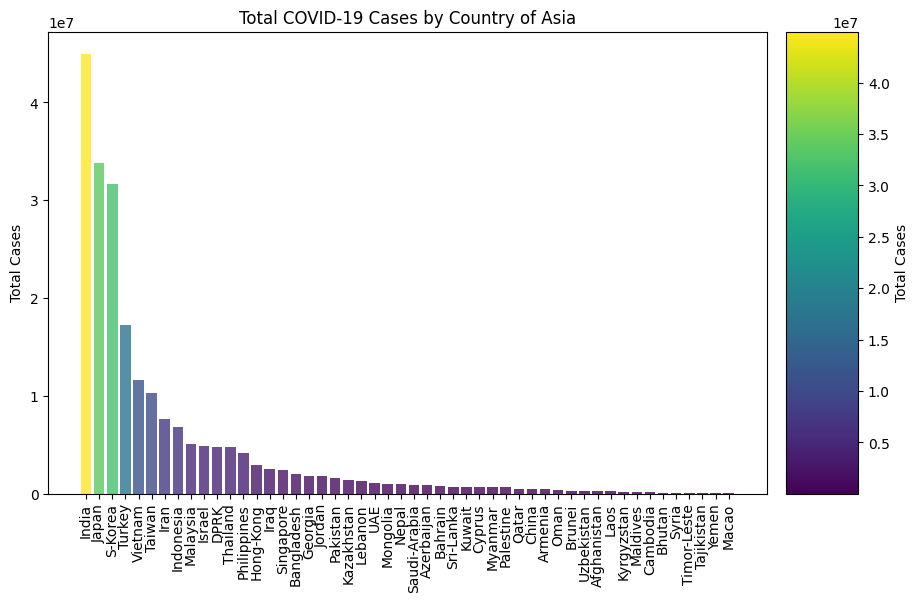

In [7]:
# Query MongoDB to get the total cases by country
total_cases_by_country = {}
for record in collection_world.find({"continent": "Asia"}):
    country = record["country"]
    total_cases = record["cases"]["total"]
    if country in total_cases_by_country:
        total_cases_by_country[country] += total_cases
    else:
        total_cases_by_country[country] = total_cases
print(total_cases_by_country)

countries = list(total_cases_by_country.keys())
cases = list(total_cases_by_country.values())



# Assuming you have the countries and cases data

# Sort the countries and cases in descending order by total cases
sorted_data = sorted(zip(countries, cases), key=lambda x: x[1], reverse=True)
countries, cases = zip(*sorted_data)

# Create a color gradient based on the cases range
cmap = plt.get_cmap('viridis')
normalize = plt.Normalize(vmin=min(cases), vmax=max(cases))
colors = [cmap(normalize(c)) for c in cases]

# Set the figure size and adjust the gap spacing
plt.figure(figsize=(12, 6))
plt.subplots_adjust(right=0.8)  # Adjust the right spacing
gs = plt.GridSpec(1, 2, width_ratios=[10, 1], wspace=0.05)  # Adjust the gap spacing

# Create the bar graph
plt.subplot(gs[0])
bars = plt.bar(countries, cases, color=colors, alpha=0.8)

# Add labels and annotations
plt.ylabel('Total Cases')
plt.title('Total COVID-19 Cases by Country of Asia')
plt.xticks(rotation=90)

# Create the color bar
plt.subplot(gs[1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm, cax=plt.gca(), orientation='vertical')
cbar.set_label('Total Cases')

plt.show()


{'Anguilla': 3904, 'Saint-Pierre-Miquelon': 3452, 'Montserrat': 1403, 'Cura&ccedil;ao': 45986, 'Cayman-Islands': 31472, 'Nicaragua': 18491, 'Dominica': 15760, 'Greenland': 11971, 'Antigua-and-Barbuda': 9106, 'British-Virgin-Islands': 7305, 'Caribbean-Netherlands': 11682, 'Bermuda': 18860, 'Sint-Maarten': 11030, 'Saint-Lucia': 30052, 'Grenada': 19693, 'Bahamas': 38084, 'Turks-and-Caicos': 6588, 'Aruba': 44180, 'St-Vincent-Grenadines': 9631, 'Saint-Martin': 12303, 'St-Barth': 5494, 'Haiti': 34246, 'Saint-Kitts-and-Nevis': 6602, 'El-Salvador': 201785, 'Belize': 70782, 'Trinidad-and-Tobago': 191496, 'Panama': 1038642, 'Honduras': 472619, 'Barbados': 107794, 'Dominican-Republic': 661176, 'Martinique': 229975, 'Guadeloupe': 202836, 'Jamaica': 154993, 'Costa-Rica': 1230552, 'Mexico': 7614771, 'Canada': 4673256, 'Cuba': 1114127, 'USA': 107092736, 'Guatemala': 1252170}


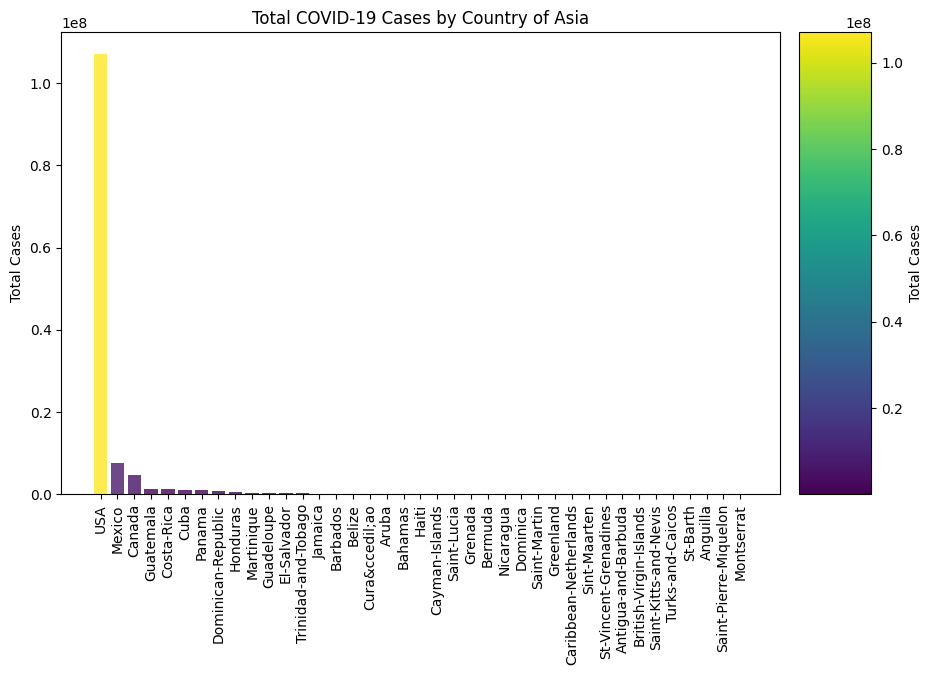

In [12]:
# Query MongoDB to get the total cases by country
total_cases_by_country = {}
for record in collection_world.find({"continent": "North-America"}):
    country = record["country"]
    total_cases = record["cases"]["total"]
    if country in total_cases_by_country:
        total_cases_by_country[country] += total_cases
    else:
        total_cases_by_country[country] = total_cases
print(total_cases_by_country)

countries = list(total_cases_by_country.keys())
cases = list(total_cases_by_country.values())



# Assuming you have the countries and cases data

# Sort the countries and cases in descending order by total cases
sorted_data = sorted(zip(countries, cases), key=lambda x: x[1], reverse=True)
countries, cases = zip(*sorted_data)

# Create a color gradient based on the cases range
cmap = plt.get_cmap('viridis')
normalize = plt.Normalize(vmin=min(cases), vmax=max(cases))
colors = [cmap(normalize(c)) for c in cases]

# Set the figure size and adjust the gap spacing
plt.figure(figsize=(12, 6))
plt.subplots_adjust(right=0.8)  # Adjust the right spacing
gs = plt.GridSpec(1, 2, width_ratios=[10, 1], wspace=0.05)  # Adjust the gap spacing

# Create the bar graph
plt.subplot(gs[0])
bars = plt.bar(countries, cases, color=colors, alpha=0.8)

# Add labels and annotations
plt.ylabel('Total Cases')
plt.title('Total COVID-19 Cases by Country of North America')
plt.xticks(rotation=90)

# Create the color bar
plt.subplot(gs[1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm, cax=plt.gca(), orientation='vertical')
cbar.set_label('Total Cases')

plt.show()


{'Falkland-Islands': 1930, 'French-Guiana': 98041, 'Venezuela': 552695, 'Suriname': 82513, 'Ecuador': 1061766, 'Guyana': 73207, 'Uruguay': 1038774, 'Paraguay': 810581, 'Brazil': 37579028, 'Colombia': 6367600, 'Bolivia': 1198858, 'Peru': 4505466, 'Chile': 5287342, 'Argentina': 10054251}


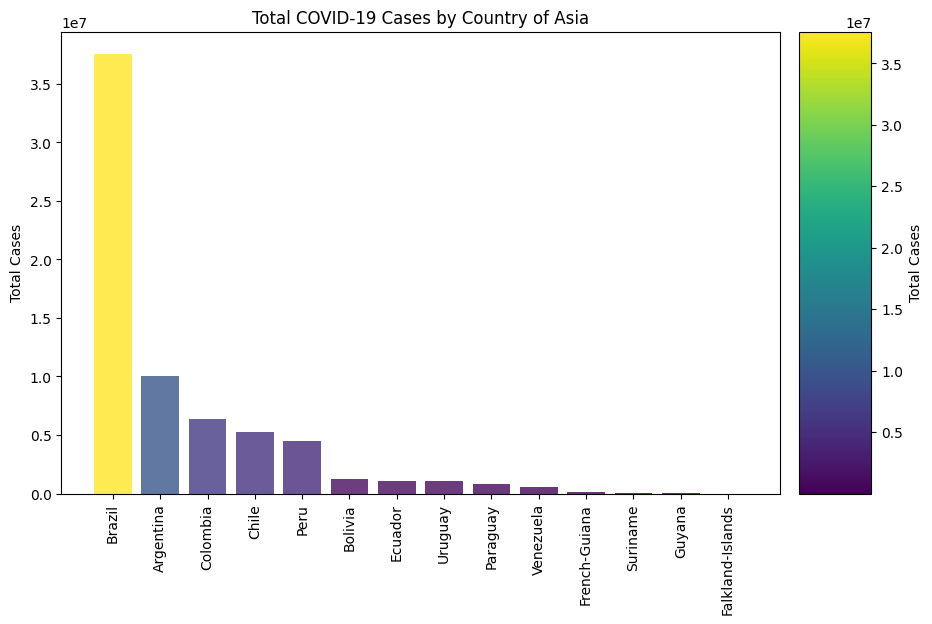

In [13]:
# Query MongoDB to get the total cases by country
total_cases_by_country = {}
for record in collection_world.find({"continent": "South-America"}):
    country = record["country"]
    total_cases = record["cases"]["total"]
    if country in total_cases_by_country:
        total_cases_by_country[country] += total_cases
    else:
        total_cases_by_country[country] = total_cases
print(total_cases_by_country)

countries = list(total_cases_by_country.keys())
cases = list(total_cases_by_country.values())



# Assuming you have the countries and cases data

# Sort the countries and cases in descending order by total cases
sorted_data = sorted(zip(countries, cases), key=lambda x: x[1], reverse=True)
countries, cases = zip(*sorted_data)

# Create a color gradient based on the cases range
cmap = plt.get_cmap('viridis')
normalize = plt.Normalize(vmin=min(cases), vmax=max(cases))
colors = [cmap(normalize(c)) for c in cases]

# Set the figure size and adjust the gap spacing
plt.figure(figsize=(12, 6))
plt.subplots_adjust(right=0.8)  # Adjust the right spacing
gs = plt.GridSpec(1, 2, width_ratios=[10, 1], wspace=0.05)  # Adjust the gap spacing

# Create the bar graph
plt.subplot(gs[0])
bars = plt.bar(countries, cases, color=colors, alpha=0.8)

# Add labels and annotations
plt.ylabel('Total Cases')
plt.title('Total COVID-19 Cases by Country of Asia')
plt.xticks(rotation=90)

# Create the color bar
plt.subplot(gs[1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
sm.set_array([])
cbar = plt.colorbar(sm, cax=plt.gca(), orientation='vertical')
cbar.set_label('Total Cases')

plt.show()


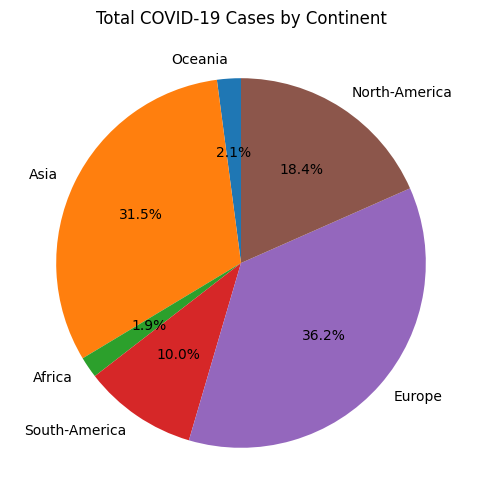

In [8]:
total_cases_by_continent = collection_world.aggregate([
    {"$group": {"_id": "$continent", "total_cases": {"$sum": "$cases.total"}}},
])

# Extract the continents and total cases as separate lists
continents = []
total_cases = []
for continent in total_cases_by_continent:
    continents.append(continent["_id"])
    total_cases.append(continent["total_cases"])

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(total_cases, labels=continents, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title("Total COVID-19 Cases by Continent")

# Display the chart
plt.show()


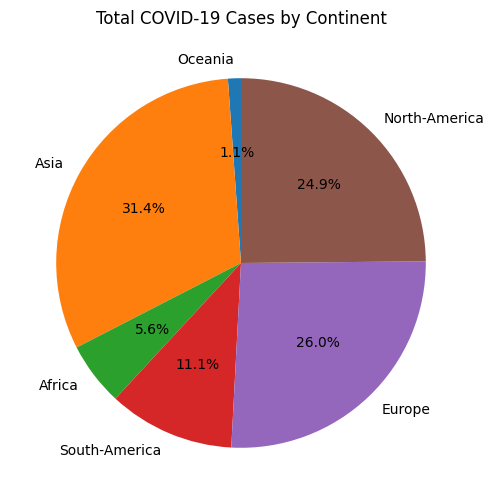

In [9]:
# Aggregate the total cases by continent
total_cases_by_continent = collection_world.aggregate([
    {"$group": {"_id": "$continent", "total_cases": {"$sum": "$cases.active"}}},
])

# Extract the continents and total cases as separate lists
continents = []
total_cases = []
for continent in total_cases_by_continent:
    continents.append(continent["_id"])
    total_cases.append(continent["total_cases"])

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(total_cases, labels=continents, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title("Total COVID-19 Cases by Continent")

# Display the chart
plt.show()


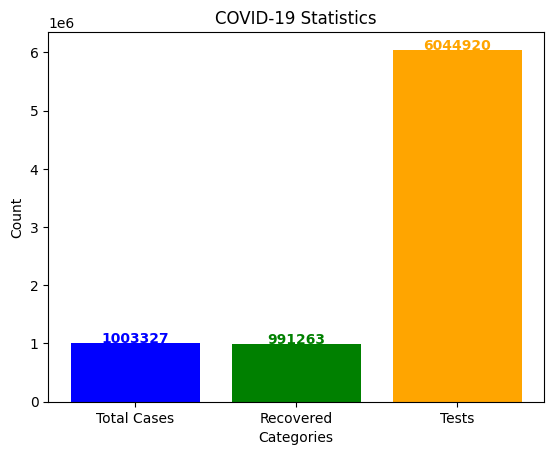

In [10]:
# Retrieve data from the collection
data = collection_nepal.find_one()

# Extract the required values
total_cases = data['cases']['total']
recovered_cases = data['cases']['recovered']
total_tests = data['tests']['total']

# Create the bar chart
categories = ['Total Cases', 'Recovered', 'Tests']
values = [total_cases, recovered_cases, total_tests]

colors = ['blue', 'green', 'orange']

plt.bar(categories, values, color=colors)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('COVID-19 Statistics')

# Add a legend with the data
for category, value, color in zip(categories, values, colors):
    plt.text(category, value + 5000, str(value), ha='center', color=color, weight='bold')

plt.show()


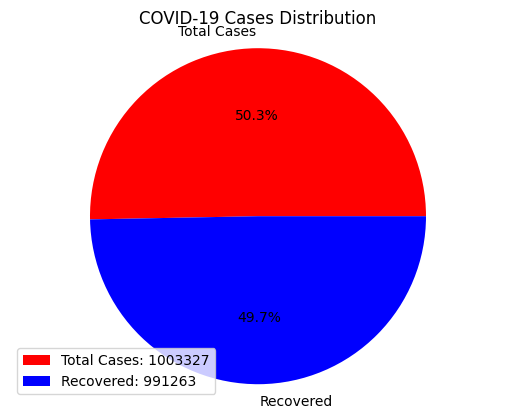

In [11]:
data = collection_nepal.find_one()

# Extract the required values
total_cases = data['cases']['total']
recovered = data['cases']['recovered']

# Create the pie chart
categories = ['Total Cases', 'Recovered']
values = [total_cases, recovered]

colors = ['red', 'blue']

plt.pie(values, labels=categories, colors=colors, autopct='%1.1f%%')
plt.title('COVID-19 Cases Distribution')
plt.axis('equal')

legend_labels = [f"{category}: {value}" for category, value in zip(categories, values)]
plt.legend(legend_labels, loc='best')

plt.show()